In [1]:
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder.appName("TitanicML").getOrCreate()

# Cargar el dataset CSV
df = spark.read.csv("titanic3.csv", header=True, inferSchema=True)


# Analisis Exploratorio 

In [2]:
df.show(5)

+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+
|pclass|survived|                name|   sex|   age|sibsp|parch|ticket|    fare|  cabin|embarked|boat|body|           home.dest|
+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+
|     1|       1|Allen, Miss. Elis...|female|  29.0|    0|    0| 24160|211.3375|     B5|       S|   2|NULL|        St Louis, MO|
|     1|       1|Allison, Master. ...|  male|0.9167|    1|    2|113781|  151.55|C22 C26|       S|  11|NULL|Montreal, PQ / Ch...|
|     1|       0|Allison, Miss. He...|female|   2.0|    1|    2|113781|  151.55|C22 C26|       S|NULL|NULL|Montreal, PQ / Ch...|
|     1|       0|Allison, Mr. Huds...|  male|  30.0|    1|    2|113781|  151.55|C22 C26|       S|NULL| 135|Montreal, PQ / Ch...|
|     1|       0|Allison, Mrs. Hud...|female|  25.0|    1|    2|113781|  151.55|C22 C26|       S|

In [3]:
# Esquema del DataFrame
df.printSchema()

root
 |-- pclass: integer (nullable = true)
 |-- survived: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: double (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: integer (nullable = true)
 |-- home.dest: string (nullable = true)



In [4]:
# Eliminar columnas irrelevantes
df = df.drop("Name", "Ticket", "Cabin")
df.show()

+------+--------+------+------+-----+-----+--------+--------+----+----+--------------------+
|pclass|survived|   sex|   age|sibsp|parch|    fare|embarked|boat|body|           home.dest|
+------+--------+------+------+-----+-----+--------+--------+----+----+--------------------+
|     1|       1|female|  29.0|    0|    0|211.3375|       S|   2|NULL|        St Louis, MO|
|     1|       1|  male|0.9167|    1|    2|  151.55|       S|  11|NULL|Montreal, PQ / Ch...|
|     1|       0|female|   2.0|    1|    2|  151.55|       S|NULL|NULL|Montreal, PQ / Ch...|
|     1|       0|  male|  30.0|    1|    2|  151.55|       S|NULL| 135|Montreal, PQ / Ch...|
|     1|       0|female|  25.0|    1|    2|  151.55|       S|NULL|NULL|Montreal, PQ / Ch...|
|     1|       1|  male|  48.0|    0|    0|   26.55|       S|   3|NULL|        New York, NY|
|     1|       1|female|  63.0|    1|    0| 77.9583|       S|  10|NULL|          Hudson, NY|
|     1|       0|  male|  39.0|    0|    0|     0.0|       S|NULL|NULL

In [5]:
# Renombrar columnas 
df = df.withColumnRenamed("home.dest", "home_dest")
df.show(5)

+------+--------+------+------+-----+-----+--------+--------+----+----+--------------------+
|pclass|survived|   sex|   age|sibsp|parch|    fare|embarked|boat|body|           home_dest|
+------+--------+------+------+-----+-----+--------+--------+----+----+--------------------+
|     1|       1|female|  29.0|    0|    0|211.3375|       S|   2|NULL|        St Louis, MO|
|     1|       1|  male|0.9167|    1|    2|  151.55|       S|  11|NULL|Montreal, PQ / Ch...|
|     1|       0|female|   2.0|    1|    2|  151.55|       S|NULL|NULL|Montreal, PQ / Ch...|
|     1|       0|  male|  30.0|    1|    2|  151.55|       S|NULL| 135|Montreal, PQ / Ch...|
|     1|       0|female|  25.0|    1|    2|  151.55|       S|NULL|NULL|Montreal, PQ / Ch...|
+------+--------+------+------+-----+-----+--------+--------+----+----+--------------------+
only showing top 5 rows



# Imputar valores Nulos

In [6]:
# Conteo de valores nulos por columna
from pyspark.sql.functions import col, sum as sum_

df.select([sum_(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+------+--------+---+---+-----+-----+----+--------+----+----+---------+
|pclass|survived|sex|age|sibsp|parch|fare|embarked|boat|body|home_dest|
+------+--------+---+---+-----+-----+----+--------+----+----+---------+
|     0|       0|  0|263|    0|    0|   1|       2| 823|1188|      564|
+------+--------+---+---+-----+-----+----+--------+----+----+---------+



In [7]:
# Imputar por la Mediana

from pyspark.sql.functions import col, when, mean, percentile_approx
# Mediana de "age"
mediana_age = df.select(percentile_approx("age", 0.5)).first()[0]
# Imputar valores nulos en "age"
df = df.withColumn("age", when(col("age").isNull(), mediana_age).otherwise(col("age")))

In [8]:
# Imputar por la Media o Promedio

# Media de "fare"
media_fare = df.select(mean(col("fare"))).first()[0]
df = df.withColumn("fare", when(col("fare").isNull(), media_fare).otherwise(col("fare")))

# Media de "body"
media_body = df.select(mean(col("body"))).first()[0]
df = df.withColumn("body", when(col("body").isNull(), media_body).otherwise(col("body")))

In [9]:
# Imputar columna 'object'

# Imputar "Sin Informacion" en "embarked"
df = df.withColumn("embarked", when(col("embarked").isNull(), "Sin Informacion").otherwise(col("embarked")))

# Imputar "Sin Informacion" en "home_dest"
df = df.withColumn("home_dest", when(col("home_dest").isNull(), "Sin Informacion").otherwise(col("home_dest")))

# Imputar "Sin Informacion" en "boat"
df = df.withColumn("boat", when(col("boat").isNull(), "Sin Informacion").otherwise(col("boat")))

In [10]:
# Verificar valores NaN
from pyspark.sql.functions import col, sum as sum_

df.select([sum_(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+------+--------+---+---+-----+-----+----+--------+----+----+---------+
|pclass|survived|sex|age|sibsp|parch|fare|embarked|boat|body|home_dest|
+------+--------+---+---+-----+-----+----+--------+----+----+---------+
|     0|       0|  0|  0|    0|    0|   0|       0|   0|   0|        0|
+------+--------+---+---+-----+-----+----+--------+----+----+---------+



In [11]:
# Esquema del DataFrame
df.printSchema()

root
 |-- pclass: integer (nullable = true)
 |-- survived: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- embarked: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- body: double (nullable = true)
 |-- home_dest: string (nullable = true)



# Separar variables 

In [12]:
# Contar cuántos valores únicos hay en "embarked"
df.select("embarked").distinct().count()

4

In [13]:
df.select("boat").distinct().count()

28

In [14]:
df.select("home_dest").distinct().count()

370

In [15]:
df = df.drop("boat", "home_dest")

In [16]:
df.show(5)

+------+--------+------+------+-----+-----+--------+--------+-----------------+
|pclass|survived|   sex|   age|sibsp|parch|    fare|embarked|             body|
+------+--------+------+------+-----+-----+--------+--------+-----------------+
|     1|       1|female|  29.0|    0|    0|211.3375|       S|160.8099173553719|
|     1|       1|  male|0.9167|    1|    2|  151.55|       S|160.8099173553719|
|     1|       0|female|   2.0|    1|    2|  151.55|       S|160.8099173553719|
|     1|       0|  male|  30.0|    1|    2|  151.55|       S|            135.0|
|     1|       0|female|  25.0|    1|    2|  151.55|       S|160.8099173553719|
+------+--------+------+------+-----+-----+--------+--------+-----------------+
only showing top 5 rows



In [17]:
from pyspark.ml.feature import StringIndexer

In [18]:
# Indexar la columna "embarked"
from pyspark.ml.feature import StringIndexer

# Indexar la columna "embarked" correctamente
indexer_embarked = StringIndexer(inputCol="embarked", outputCol="embarked_index")
df = indexer_embarked.fit(df).transform(df)

In [19]:
# Indexar la columna "embarked"
from pyspark.ml.feature import StringIndexer

# Indexar la columna "embarked" correctamente
indexer_embarked = StringIndexer(inputCol="sex", outputCol="sex_index")
df = indexer_embarked.fit(df).transform(df)

In [20]:
df.show(5)

+------+--------+------+------+-----+-----+--------+--------+-----------------+--------------+---------+
|pclass|survived|   sex|   age|sibsp|parch|    fare|embarked|             body|embarked_index|sex_index|
+------+--------+------+------+-----+-----+--------+--------+-----------------+--------------+---------+
|     1|       1|female|  29.0|    0|    0|211.3375|       S|160.8099173553719|           0.0|      1.0|
|     1|       1|  male|0.9167|    1|    2|  151.55|       S|160.8099173553719|           0.0|      0.0|
|     1|       0|female|   2.0|    1|    2|  151.55|       S|160.8099173553719|           0.0|      1.0|
|     1|       0|  male|  30.0|    1|    2|  151.55|       S|            135.0|           0.0|      0.0|
|     1|       0|female|  25.0|    1|    2|  151.55|       S|160.8099173553719|           0.0|      1.0|
+------+--------+------+------+-----+-----+--------+--------+-----------------+--------------+---------+
only showing top 5 rows



In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# 1. Definir las columnas que serán features o independientes o predictoras (X)
feature_cols = ["pclass", "sex_index", "age", "sibsp", "parch", "fare", "embarked_index", "body"]

# 2. Usar VectorAssembler para juntar las features en una sola columna
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# 3. Seleccionar solamente features + label que es la variable dependiente u objetivo (y)
df = df.select("features", col("survived").alias("label"))


# Separar conjuntos en Train y Test

In [22]:
# Dividir los datos (80% entrenamiento, 20% prueba)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Random Forest

📊 MÉTRICAS DEL MODELO RANDOM FOREST:
Accuracy  : 0.735
Precision : 0.731
Recall    : 0.735
F1 Score  : 0.731


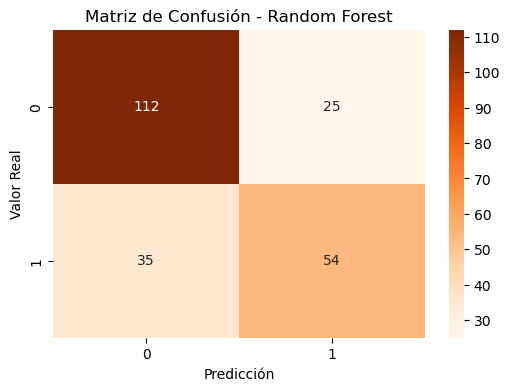

In [23]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Crear y entrenar el modelo Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
rf_model = rf.fit(train_data)

# 2. Predecir en el conjunto de prueba
rf_predictions = rf_model.transform(test_data)

# 3. Evaluar
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})

print("📊 MÉTRICAS DEL MODELO RANDOM FOREST:")
print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1 Score  : {f1:.3f}")

# 4. Matriz de confusión (gráfica)
# Convertir predicciones a Pandas
rf_pred_pandas = rf_predictions.select("prediction", "label").toPandas()

# Crear matriz
cm_rf = confusion_matrix(rf_pred_pandas["label"], rf_pred_pandas["prediction"])

# Graficar
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges")
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


In [24]:
predicciones = rf_model.transform(test_data)
# Mostrar primeras 20 comparaciones entre valor real y predicho
predicciones.select("prediction", "label").show(20)


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 20 rows



# Realizar predicciones utilizando el Random Forest

In [25]:
from pyspark.sql import Row

# CREAR NUEVO PASAJERO YA INDEXADO
nuevo_pasajero = spark.createDataFrame([
    Row(
        pclass=3,
        sex_index=0.0,   # 1.0 para 'male', 0.0 para 'female' 
        age=25.0,
        sibsp=0,
        parch=0,
        fare=100.25,
        embarked_index=0.0,  # 0.0 para 'S', 1.0 para 'C', 2.0 para 'Q' 
        body=0
    )
])

# USAR ASSEMBLER PARA ARMAR FEATURES
nuevo_pasajero = assembler.transform(nuevo_pasajero)

# PREDICCIÓN
prediccion_nuevo = rf_model.transform(nuevo_pasajero) # Aqui cambias el algoritmo entrenado

# MOSTRAR RESULTADO
prediccion_nuevo.select("prediction", "probability").show(truncate=False)


+----------+----------------------------------------+
|prediction|probability                             |
+----------+----------------------------------------+
|0.0       |[0.7676145208866901,0.23238547911330978]|
+----------+----------------------------------------+



# Arbol de Decision

📊 MÉTRICAS DEL MODELO ÁRBOL DE DECISIÓN:
Accuracy  : 0.721
Precision : 0.719
Recall    : 0.721
F1 Score  : 0.720


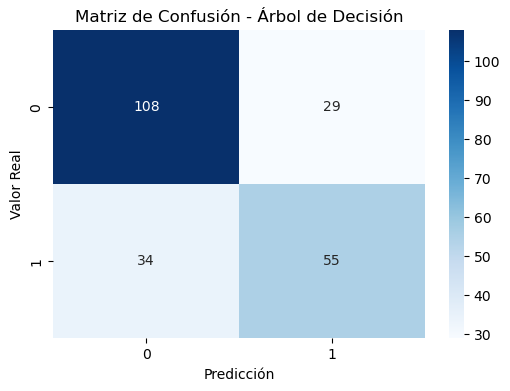

In [26]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Crear y entrenar el modelo Árbol de Decisión
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = dt.fit(train_data)

# 2. Predecir en el conjunto de prueba
dt_predictions = dt_model.transform(test_data)

# 3. Evaluar
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})
dt_f1 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})

print("📊 MÉTRICAS DEL MODELO ÁRBOL DE DECISIÓN:")
print(f"Accuracy  : {dt_accuracy:.3f}")
print(f"Precision : {dt_precision:.3f}")
print(f"Recall    : {dt_recall:.3f}")
print(f"F1 Score  : {dt_f1:.3f}")

# 4. Matriz de confusión (gráfica)
# Convertir predicciones a Pandas
dt_pred_pandas = dt_predictions.select("prediction", "label").toPandas()

# Crear matriz
cm_dt = confusion_matrix(dt_pred_pandas["label"], dt_pred_pandas["prediction"])

# Graficar
plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Árbol de Decisión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


# Naibe Bayes (Bayes Ingenuo)

📊 MÉTRICAS DEL MODELO NAIVE BAYES:
Accuracy  : 0.628
Precision : 0.612
Recall    : 0.628
F1 Score  : 0.605


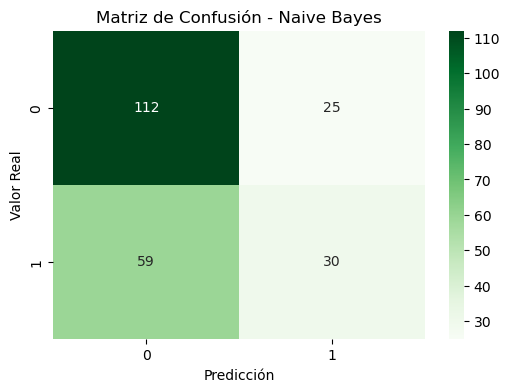

In [27]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Crear y entrenar el modelo Naive Bayes
nb = NaiveBayes(labelCol="label", featuresCol="features", smoothing=1.0, modelType="multinomial")
nb_model = nb.fit(train_data)

# 2. Predecir en el conjunto de prueba
nb_predictions = nb_model.transform(test_data)

# 3. Evaluar
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

nb_accuracy = evaluator.evaluate(nb_predictions, {evaluator.metricName: "accuracy"})
nb_precision = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedPrecision"})
nb_recall = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedRecall"})
nb_f1 = evaluator.evaluate(nb_predictions, {evaluator.metricName: "f1"})

print("📊 MÉTRICAS DEL MODELO NAIVE BAYES:")
print(f"Accuracy  : {nb_accuracy:.3f}")
print(f"Precision : {nb_precision:.3f}")
print(f"Recall    : {nb_recall:.3f}")
print(f"F1 Score  : {nb_f1:.3f}")

# 4. Matriz de confusión (gráfica)
# Convertir predicciones a Pandas
nb_pred_pandas = nb_predictions.select("prediction", "label").toPandas()

# Crear matriz
cm_nb = confusion_matrix(nb_pred_pandas["label"], nb_pred_pandas["prediction"])

# Graficar
plt.figure(figsize=(6,4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión - Naive Bayes")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()
